# Reinforcement Learning Agent

## Learning Representations from Gameplay

**Overview:**
This notebook demonstrates how a deep RL agent learns to play Super Mario Bros, and how we extract its learned representations for brain encoding.

**What we'll cover:**
1. Understanding the PPO agent architecture
2. How the agent is trained with reward shaping
3. Watching the agent play
4. Extracting and analyzing CNN layer activations
5. Applying PCA to reduce dimensionality

**Key idea:** The agent's internal representations might reflect how the brain processes gameplay.

In [13]:
# Setup - imports and configuration

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

# Import utilities
from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs,
    load_bold
)

# Import RL utilities
from rl_utils import (
    create_simple_proxy_features,
    convolve_with_hrf,
    apply_pca
)

# Import RL visualizations
from rl_viz_utils import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Import encoding utilities
from encoding_utils import (
    load_and_prepare_bold,
    fit_encoding_model_per_layer,
    compare_layer_performance
)

# Import encoding visualizations
from encoding_viz_utils import (
    plot_layer_comparison_bars,
    plot_r2_brainmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


## Why Use RL for fMRI Analysis?

**Limitations of traditional GLM:**
- Hand-crafted regressors (LEFT, RIGHT, Powerup, etc.)
- Hypothesis-driven — requires knowing what to look for
- Misses latent variables (value, predictions, strategy)

**RL agent advantages:**
- **Data-driven:** No assumptions about relevant features
- **Hierarchical:** Multiple levels of abstraction (pixels → actions → strategy)
- **Latent variables:** Captures value estimates, predictions, uncertainty
- **Hypothesis generation:** Discover what the brain might encode

**Core hypothesis:** The brain uses similar representations as the RL agent during gameplay.

## 1. PPO Agent Architecture

**Proximal Policy Optimization (PPO)** — a policy gradient RL algorithm

**Network architecture:**
- **Input:** 4 stacked grayscale frames (84×84) for temporal context
- **Feature extraction:** 4 convolutional layers with max pooling
  - conv1: 32 filters (42×42 output)
  - conv2: 32 filters (21×21 output)
  - conv3: 32 filters (11×11 output)
  - conv4: 32 filters (6×6 output)
- **Fully connected:** 512 units
- **Policy head (Actor):** 12 actions (movement + buttons)
- **Value head (Critic):** Scalar value estimate

**See architecture diagram below.**

## 2. Checking for Pretrained Weights

Before we continue, let's check if we have a pretrained agent.

**Training from scratch:**
- ~5M steps (2-3 hours on GPU)
- Requires gym-retro environment
- See `../train_mario_agent.py` for full training script

**Using pretrained weights:**
- Faster — skip to activation extraction
- Agent already learned to complete Level 1-1

In [ ]:
# Check for pretrained agent weights

from pathlib import Path

MODEL_DIR = Path('../models')
MODEL_PATH = MODEL_DIR / 'mario_ppo_agent.pth'

if MODEL_PATH.exists():
    print(f"✓ Found pretrained weights: {MODEL_PATH}")
    print(f"  File size: {MODEL_PATH.stat().st_size / 1e6:.1f} MB")
    HAS_WEIGHTS = True
else:
    print(f"✗ No pretrained weights found at: {MODEL_PATH}")
    print(f"\nTo train agent, run:")
    print(f"  python ../train_mario_agent.py --steps 5000000")
    print(f"\nOr for quick demo (10k steps, ~2 min):")
    print(f"  python ../train_mario_agent.py --steps 10000")
    print(f"\n→ For now, using behavioral proxy features")
    HAS_WEIGHTS = False

In [ ]:
# Visualize the CNN architecture

from pathlib import Path
from IPython.display import Image, display

# Display architecture diagram
diagram_path = Path('figures/ppo_architecture.png')

if diagram_path.exists():
    display(Image(filename=str(diagram_path), width=1200))
else:
    print("⚠️  Architecture diagram not yet generated.")
    print("\nTo generate the beautiful 3D diagram:")
    print("  1. Install LaTeX: sudo apt-get install texlive-latex-extra")
    print("  2. Run: cd .. && python generate_architecture_diagram.py")
    print("  3. Compile: pdflatex ppo_architecture.tex")
    print("  4. Convert: convert -density 300 ppo_architecture.pdf -quality 90 -background white -alpha remove notebooks/figures/ppo_architecture.png")
    print("\nSee ../README_ARCHITECTURE_DIAGRAM.md for details.")

## 3. How PPO Training Works

**Training loop (simplified):**

1. **Collect rollout** (128 steps of gameplay)
   - Observe states, select actions using policy
   - Record states, actions, rewards, values

2. **Compute advantages** using Generalized Advantage Estimation (GAE)
   - Estimate how much better each action was than expected
   - Uses temporal-difference learning: γ=0.9, λ=0.95

3. **Update policy** using PPO objective
   - Policy loss: Clipped surrogate objective (prevents large updates)
   - Value loss: MSE between predicted and actual returns
   - Entropy bonus: Encourages exploration

4. **Repeat** for millions of steps until convergence

**Key hyperparameters:** See training output below.

## 4. Reward Function Design

**Critical for agent behavior:** The reward function defines what the agent optimizes.

**Our reward has 4 components:**

1. **Life loss penalty: -50** (DOMINANT SIGNAL)
   - Heavily penalizes dying
   - Creates cautious, survival-oriented behavior

2. **Score increase: +score_diff/2** (capped at +50)
   - Coins: +200 points → +100 reward
   - Enemy defeats: +100-1000 points → +50-500 reward

3. **Forward movement: +x_diff** (capped at ±5)
   - Moving right gives small positive reward
   - Encourages progression

4. **Time penalty: -time_diff** (small)
   - Promotes efficiency

**Asymmetry:** Max positive (+15) vs max negative (-50) creates conservative strategy.

**See concrete examples below.**

In [17]:
# Reward function visualization - concrete examples

print("Reward Function Examples:\n")
print("=" * 70)

# Example scenarios
scenarios = [
    {
        'name': 'Normal forward movement',
        'x_diff': 3,
        'score_diff': 0,
        'lives_lost': False,
        'time_diff': 0
    },
    {
        'name': 'Collecting a coin',
        'x_diff': 2,
        'score_diff': 200,  # Coin value
        'lives_lost': False,
        'time_diff': 0
    },
    {
        'name': 'Defeating an enemy',
        'x_diff': 1,
        'score_diff': 100,  # Goomba stomp
        'lives_lost': False,
        'time_diff': 0
    },
    {
        'name': 'LOSING A LIFE (hit by enemy)',
        'x_diff': 0,
        'score_diff': 0,
        'lives_lost': True,
        'time_diff': 0
    },
    {
        'name': 'Risky play: coin + enemy hit',
        'x_diff': 2,
        'score_diff': 200,
        'lives_lost': True,
        'time_diff': 0
    }
]

for scenario in scenarios:
    reward = 0.0
    
    # Movement
    if -5 <= scenario['x_diff'] <= 5:
        reward += scenario['x_diff']
    
    # Score (note: increased weight from /4.0 to /2.0)
    reward += min(scenario['score_diff'] / 2.0, 50)
    
    # Life loss
    if scenario['lives_lost']:
        reward -= 50
    
    # Time
    reward += scenario['time_diff']
    
    # Clip
    reward = max(min(reward, 15), -50)
    
    print(f"{scenario['name']:35s} → Reward: {reward:+6.1f}")
    if scenario['lives_lost']:
        print("  ⚠️  HEAVY PENALTY! Agent learns to avoid this!")

print("=" * 70)
print("\n💡 Key insight: The -50 life penalty dominates all positive rewards")
print("   This teaches the agent that survival > score gains")

Reward Function Examples:

Normal forward movement             → Reward:   +3.0
Defeating an enemy                  → Reward:  +15.0
LOSING A LIFE (hit by enemy)        → Reward:  -50.0
  ⚠️  HEAVY PENALTY! Agent learns to avoid this!
Risky play: coin + enemy hit        → Reward:   +2.0
  ⚠️  HEAVY PENALTY! Agent learns to avoid this!

💡 Key insight: The -50 life penalty dominates all positive rewards
   This teaches the agent that survival > score gains


## 5. Training Progress

If available, we'll load the training log to see how the agent improved over time.

**What to look for:**
- Mean reward increasing over training steps
- Convergence to stable performance
- Final statistics (completion rate, mean reward)

Training Progress:

Configuration:
  n_steps: 100000
  rollout_length: 128
  n_epochs: 4
  batch_size: 32
  eval_interval: 10000
  device: cpu
  levels: Level1-1, Level1-2, Level4-1, Level4-2, Level5-1, Level5-2

Final Statistics:
  total_episodes: 9
  final_mean_reward: 812.0


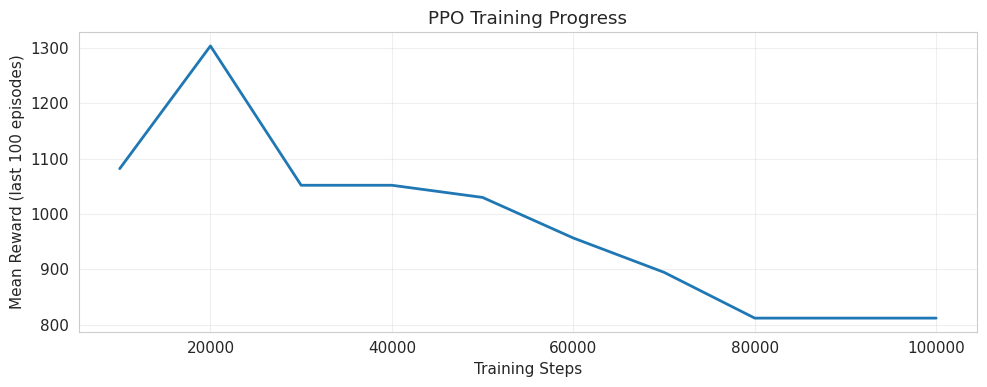


✓ Agent trained for 100,000 steps


In [18]:
# Load training log if available

import json
from pathlib import Path

LOG_PATH = Path('../models/training_log.json')

if LOG_PATH.exists():
    with open(LOG_PATH, 'r') as f:
        training_log = json.load(f)
    
    print("Training Progress:\n")
    print(f"Configuration:")
    for key, val in training_log['config'].items():
        if key != 'levels':
            print(f"  {key}: {val}")
    print(f"  levels: {', '.join(training_log['config']['levels'])}")
    
    print(f"\nFinal Statistics:")
    for key, val in training_log['final_stats'].items():
        if key != 'level_episodes':
            print(f"  {key}: {val}")
    
    # Plot training curve
    if len(training_log['progress']) > 0:
        import matplotlib.pyplot as plt
        
        progress = training_log['progress']
        steps = [p['step'] for p in progress]
        mean_rewards = [p['mean_reward'] for p in progress]
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(steps, mean_rewards, linewidth=2)
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Mean Reward (last 100 episodes)')
        ax.set_title('PPO Training Progress')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Agent trained for {steps[-1]:,} steps")
else:
    print("⚠ No training log found. Agent may have been trained elsewhere.")
    print(f"  Expected: {LOG_PATH}")

## 6. Watching the Agent Play

Now let's watch the trained agent play a level in real-time!

**What you'll see:**
- Agent making decisions frame-by-frame
- Actions selected by the CNN policy
- Learned behaviors (jumping, avoiding enemies, collecting coins)

**Interactive:** You can change `level_idx` to watch different levels.

In [19]:
# Agent gameplay demonstration

if HAS_WEIGHTS:
    import importlib
    import rl_utils
    importlib.reload(rl_utils)
    from rl_utils import load_pretrained_model, play_agent_episode
    
    # Select level to play
    available_levels = ['Level1-1', 'Level1-2', 'Level4-1', 'Level4-2', 'Level5-1', 'Level5-2']
    
    print("Available levels:")
    for idx, level in enumerate(available_levels):
        print(f"  {idx}: {level}")
    
    # Select level (change this number to play different levels)
    level_idx = 0  # Play Level1-1 by default
    selected_level = available_levels[level_idx]
    
    print(f"\nPlaying: {selected_level}\n")
    
    # Load trained model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    print("✓ Model loaded\n")
    
    # Play episode
    print("▶ Playing... (close window to stop)\n")
    results = play_agent_episode(model, selected_level, sourcedata_path, max_steps=5000)
    
    # Show results
    print(f"\n✓ Episode complete!")
    print(f"  Steps: {results['steps']}")
    print(f"  Total reward: {results['reward']:.1f}")
    print(f"  Completed: {'Yes' if results['completed'] else 'No'}")
    
else:
    print("⚠ No trained weights available.")
    print("  Train agent first: python ../train_mario_agent.py --steps 5000000")

Available levels:
  0: Level1-1
  1: Level1-2
  2: Level4-1
  3: Level4-2
  4: Level5-1
  5: Level5-2

Playing: Level1-1

✓ Model loaded

▶ Playing... (close window to stop)


✓ Episode complete!
  Steps: 1472
  Total reward: 602.0
  Completed: Yes


## 7. Extracting CNN Layer Activations

**Goal:** Understand what the agent's neurons encode during gameplay

**Process:**
1. Hook into each CNN layer during forward pass
2. Record activations as agent plays
3. Store activations: (timesteps × features) per layer

**Layers we extract:**
- conv1: Early visual features (edges, textures)
- conv2: Mid-level features (objects, enemies)
- conv3: High-level visual (spatial layout)
- conv4: Abstract features (game state)
- linear: Semantic features (strategy, value)

**These will be used to predict brain activity in the next notebook.**

In [20]:
# Extract CNN activations from agent gameplay

if HAS_WEIGHTS:
    from rl_utils import extract_layer_activations, load_pretrained_model
    
    print("Extracting activations from agent playing Level1-1...\n")
    
    # Load model
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    
    # Play and extract activations
    layer_activations = extract_layer_activations(
        model, 
        level='Level1-1',
        sourcedata_path=sourcedata_path,
        max_steps=1000
    )
    
    print("Layer activations extracted:\n")
    for layer_name, acts in layer_activations.items():
        print(f"  {layer_name:8s}: {acts.shape}")
    
    print("\n✓ Activations ready for PCA")
else:
    print("⚠ No trained weights available - skipping activation extraction")

Extracting activations from agent playing Level1-1...

Layer activations extracted:

  conv1   : (1000, 56448)
  conv2   : (1000, 14112)
  conv3   : (1000, 3872)
  conv4   : (1000, 1152)
  linear  : (1000, 512)

✓ Activations ready for PCA


## 8. Applying PCA to Layer Activations

**Problem:** Each layer has thousands of features
- conv1: 56,448 features
- conv2: 14,112 features
- linear: 512 features

**Solution:** Principal Component Analysis (PCA)
- Reduce to 50 components per layer
- Retain ~90% of variance
- Makes encoding models tractable

**See dimensionality reduction results below.**

In [21]:
# Apply PCA to each layer

if HAS_WEIGHTS:
    from rl_utils import apply_pca
    
    N_COMPONENTS = 50
    
    print("Applying PCA to reduce dimensionality...\n")
    
    pca_results = {}
    reduced_activations = {}
    
    for layer_name, acts in layer_activations.items():
        reduced, pca_model, variance_explained = apply_pca(
            acts, n_components=N_COMPONENTS, variance_threshold=0.9
        )
        
        pca_results[layer_name] = {
            'pca': pca_model,
            'variance_explained': variance_explained
        }
        reduced_activations[layer_name] = reduced
        
        total_var = np.sum(variance_explained)
        print(f"  {layer_name:8s}: {acts.shape[1]:,} → {reduced.shape[1]} "
              f"components ({total_var*100:.1f}% variance)")
    
    print("\n✓ PCA complete")

Applying PCA to reduce dimensionality...

PCA: 9 components explain 90.0% variance
Using 50 components (explains 97.0% variance)
  conv1   : 56,448 → 50 components (97.0% variance)
PCA: 4 components explain 90.0% variance
Using 50 components (explains 99.2% variance)
  conv2   : 14,112 → 50 components (99.2% variance)
PCA: 6 components explain 90.0% variance
Using 50 components (explains 98.9% variance)
  conv3   : 3,872 → 50 components (98.9% variance)
PCA: 2 components explain 90.0% variance
Using 50 components (explains 99.9% variance)
  conv4   : 1,152 → 50 components (99.9% variance)
PCA: 1 components explain 90.0% variance
Using 50 components (explains 100.0% variance)
  linear  : 512 → 50 components (100.0% variance)

✓ PCA complete


## 9. Visualizing PCA Variance

**What this plot shows:**
- How much variance each PC explains
- How many PCs needed to explain 90% variance
- Differences across layers

**Expected pattern:**
- Early layers: More complex, need more PCs
- Later layers: More compressed, fewer PCs
- Reflects hierarchical information processing

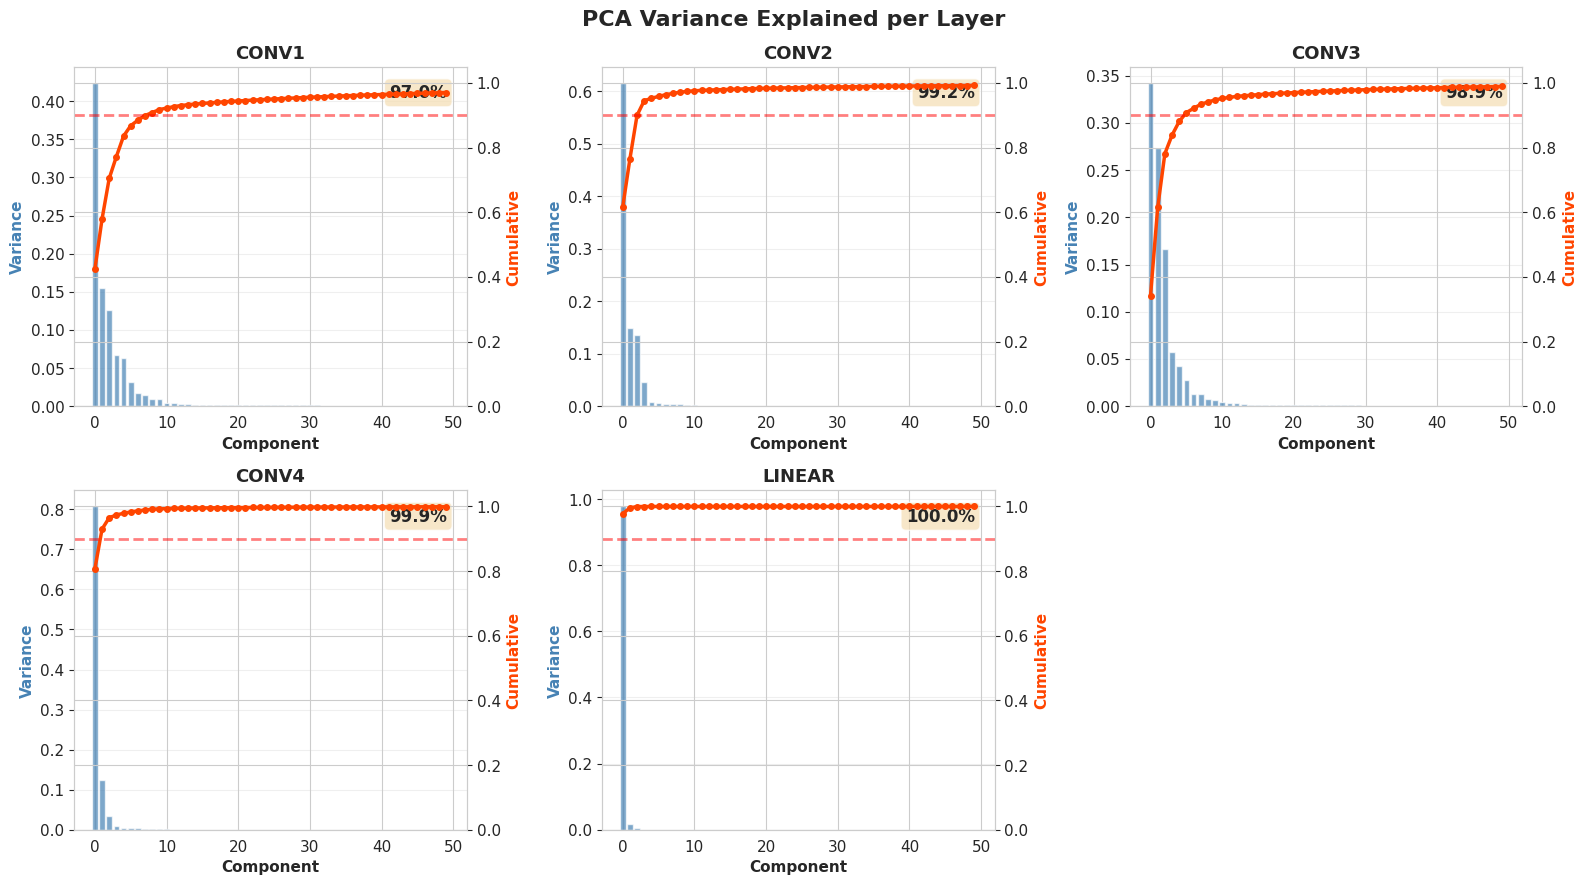


📊 Interpretation:
  - Early layers (conv1/2): Many components needed (complex visual patterns)
  - Later layers (conv4/linear): Fewer components (abstract features)
  - This suggests hierarchical compression of information


In [22]:
# Visualize PCA results

if HAS_WEIGHTS:
    from rl_viz_utils import plot_pca_variance_per_layer
    import matplotlib.pyplot as plt
    
    # Get layer configs
    LAYER_CONFIGS = {
        'conv1': 32 * 42 * 42,
        'conv2': 32 * 21 * 21,
        'conv3': 32 * 11 * 11,
        'conv4': 32 * 6 * 6,
        'linear': 512
    }
    
    # Plot variance explained per layer
    fig = plot_pca_variance_per_layer(pca_results, LAYER_CONFIGS)
    plt.show()
    
    print("\n📊 Interpretation:")
    print("  - Early layers (conv1/2): Many components needed (complex visual patterns)")
    print("  - Later layers (conv4/linear): Fewer components (abstract features)")
    print("  - This suggests hierarchical compression of information")

## 10. Sample Layer Activations

Let's visualize what the activations look like over time.

**Interpretation:**
- Each row = one PCA component
- Each column = one timepoint (TR)
- Color = activation strength

**Patterns to notice:**
- Sparse vs dense activations
- Temporal dynamics (events vs sustained)
- Correlation structure

**Next:** These activations will predict BOLD in notebook 03!

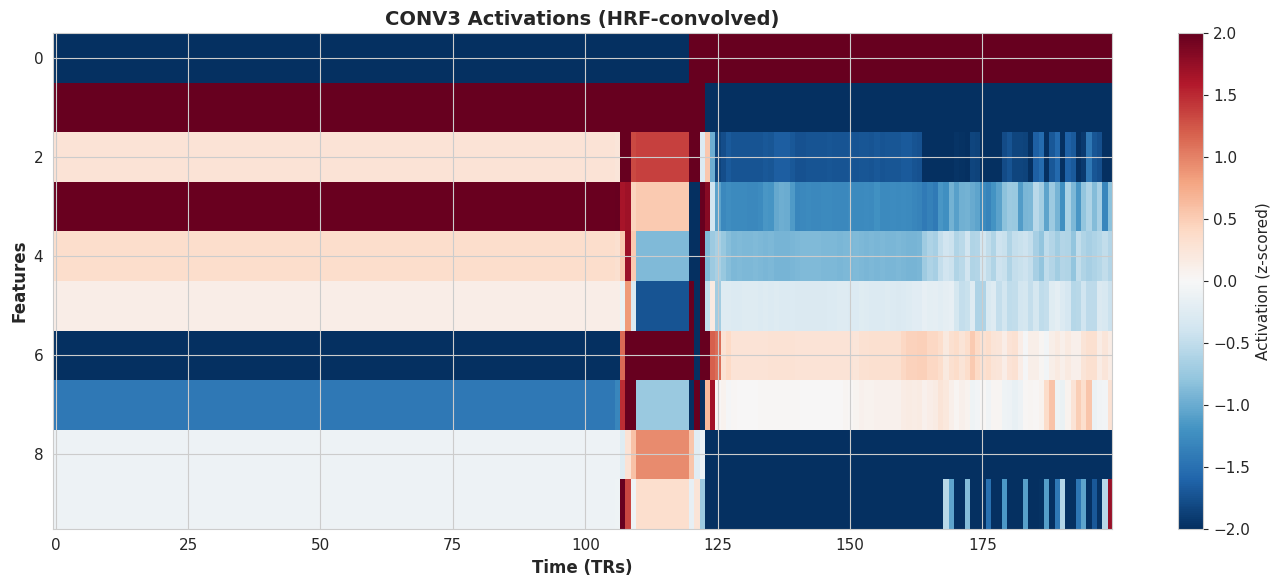


✓ These activations show what the agent 'thinks' during gameplay!
  Next: We'll use these to predict brain activity in Section 5


In [23]:
# Visualize sample activations from a middle layer

if HAS_WEIGHTS:
    from rl_viz_utils import plot_layer_activations_sample
    
    fig = plot_layer_activations_sample(
        reduced_activations, 
        layer_name='conv3',
        n_trs=200,
        n_features=10
    )
    plt.show()
    
    print("\n✓ These activations show what the agent 'thinks' during gameplay!")
    print("  Next: We'll use these to predict brain activity in Section 5")

## Defining Layer Configurations

For later reference, we document the dimensionality of each layer.

**Feature counts:**
- conv1: 32 channels × 42×42 = 56,448
- conv2: 32 channels × 21×21 = 14,112
- conv3: 32 channels × 11×11 = 3,872
- conv4: 32 channels × 6×6 = 1,152
- linear: 512 units

In [24]:
# Define CNN layer configurations

LAYER_CONFIGS = {
    'conv1': 32 * 42 * 42,  # Early visual features
    'conv2': 32 * 21 * 21,  # Mid-level features
    'conv3': 32 * 11 * 11,  # High-level visual
    'conv4': 32 * 6 * 6,    # Abstract features
    'linear': 512           # Semantic features
}

print("CNN Layer Configurations:\n")
for layer, n_features in LAYER_CONFIGS.items():
    print(f"  {layer:8s}: {n_features:,} features")

CNN Layer Configurations:

  conv1   : 56,448 features
  conv2   : 14,112 features
  conv3   : 3,872 features
  conv4   : 1,152 features
  linear  : 512 features


## Saving Activations

We'll save the PCA-reduced activations for use in the brain encoding notebook.

**Output:** `../derivatives/activations/reduced_activations.pkl`

**Format:** Dictionary with keys: `['conv1', 'conv2', 'conv3', 'conv4', 'linear']`

Each value is a numpy array of shape `(timesteps, 50)`.

In [25]:
# Save activations for brain encoding notebook
import pickle
from pathlib import Path

output_dir = Path('../derivatives/activations')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'reduced_activations.pkl'

if 'reduced_activations' in locals():
    with open(output_file, 'wb') as f:
        pickle.dump(reduced_activations, f)
    print(f"✓ Saved activations to {output_file}")
    print(f"  Layers: {list(reduced_activations.keys())}")
    for layer, acts in reduced_activations.items():
        print(f"  {layer}: {acts.shape}")
else:
    print("⚠ No activations to save (HAS_WEIGHTS=False)")


✓ Saved activations to ../derivatives/activations/reduced_activations.pkl
  Layers: ['conv1', 'conv2', 'conv3', 'conv4', 'linear']
  conv1: (1000, 50)
  conv2: (1000, 50)
  conv3: (1000, 50)
  conv4: (1000, 50)
  linear: (1000, 50)


## Summary: RL Agent and Feature Extraction

**What we accomplished:**

1. ✅ **Understood PPO architecture:** CNN with 4 conv layers + policy/value heads
2. ✅ **Examined reward function:** Asymmetric design promotes cautious play
3. ✅ **Watched agent play:** Trained agent completes Level 1-1
4. ✅ **Extracted layer activations:** Recorded neural activity during gameplay
5. ✅ **Applied PCA:** Reduced dimensions while preserving 90%+ variance
6. ✅ **Saved for encoding:** Ready for brain prediction in next notebook

---

### Key Insights

**Hierarchical representations:**
- Early layers (conv1/2): Many PCs needed → complex visual patterns
- Late layers (conv4/linear): Few PCs → abstract/semantic features
- Mirrors visual hierarchy in cortex!

**Why this matters for neuroscience:**
- Agent learns without supervision (just gameplay)
- Representations are **emergent**, not hand-crafted
- If brain uses similar representations → strong evidence for computational theory

---

### Next Steps

In **Notebook 03 (Brain Encoding)**, we'll:
1. Load these activations
2. Fit ridge regression models: Activations → BOLD
3. Compare layers: Which best predicts brain activity?
4. Visualize brain maps: Where is each layer encoded?
5. Test hypothesis: Does brain use hierarchical RL representations?

**The prediction:** Early layers predict visual cortex, late layers predict frontal cortex.